In [82]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import seaborn as sns
import statistics as stats
import matplotlib.pyplot as plt
from IPython.display import display

In [83]:
class Paciente():
    def __init__(self,prefijo,tipo):
        self.prefijo = prefijo
        self.tiempoLlegada = round(np.random.poisson(220)) #llegada de pacienes con media=220 y poisson
        self.tipo = tipo
        if tipo == "INTERNACION":
            self.duracionInternacion = round(np.random.uniform(1,3)) * (24*60)
        else: # operacion
            self.duracionInternacion = round(np.random.uniform(2,5)) * (24*60) #2 y 5 días para pacientes operados 
            self.duracionOperacion = np.random.uniform(1,6) * 60

In [84]:
class Cama():
    def __init__(self, id):
        self.id = id
        self.ocupada = False
        self.contador_ocupacion = 0
    
    def marcarOcupada(self):
        self.ocupada = True
    
    def marcarDesocupada(self):
        self.ocupada = False
    
    def actualizar_ocupacion(self):
        self.contador_ocupacion += 1

In [85]:
class Quirofano():
    def __init__(self,id):
        self.id = id
        self.ocupado = False
        self.abierto = True
        self.tiempoOcupacion = 0
    
    def marcarOcupado(self):
        self.ocupado = True
    
    def marcarDesocupado(self):
        self.ocupado = False
    
    def actualizarTiempoOcupacion(self, tiempo):
        self.tiempoOcupacion += tiempo

In [86]:
class Evento():
    def __init__(self, _id, nombre, objeto, arribo, duracion):
        self.id = _id
        self.nombre = nombre
        self.arribo = arribo
        self.duracion = duracion
        self.tiempo_fin = arribo + duracion
        self.objeto = objeto
        
    def __repr__(self):
        return "f{self.id} - {self.nombre} - arribo: {self.arribo} - duracion: {self.duracion} - termina: {self.tiempo_fin}\n"
    
    
class EventoFinalizacion(Evento):
    def __init__(self, evento_inicio, **kwargs):
        Evento.__init__(self,**kwargs)
        self.evento_inicio = evento_inicio
    
    def __repr__(self):
        return "f{self.id} - {self.nombre} a {self.evento_inicio.id} - inicia: {self.arribo} - duracion: {self.duracion} - termina: {self.tiempo_fin}\n"

In [87]:
def hayCamaLibre(lista_camas):
    """
    Consulta si hay una cama libre
    """
    return any(not cama.ocupada for cama in lista_camas)

In [88]:
def hayQuirofanoLibre(lista_quirofanos):
    """
    Consulta si hay un quirofano libre
    """
    return any(not quirofano.ocupado for quirofano in lista_quirofanos)

In [89]:
def ordenarEventos(fel):
    """
    Ordena la lista de eventos por tiempod de arribo
    """
    fel.sort(key=lambda evento: evento.arribo)
    return fel

In [90]:
def removerEvento(fel, evento):
    """
    remueve el siguiente evento de la FEL
    """
    if evento in fel:
        fel.remove(evento)
    return ordenarEventos(fel)

In [91]:
def crearFEL(paciente, cantidad_pacientes):
    """
    Crea la FEL con eventos de arribo paciente segun el tipo
    de paciente y la cantidad de pacientes que arriban
    """
    lista_eventos = []
    for i in range(cantidad_pacientes):
        lista_eventos.append()
    return ordenarEventos(lista_eventos)

In [92]:
def inicializarModelo(prefijo, cantidad_corridas, cantidad_pacientes, cantidad_camas):
    """
    En este caso corrida va a ir a la par con el reloj
    """
    fel = {}
    lista_camas = []

    
    #Inicializamos la fel
    for id_paciente in range(cantidad_pacientes): 
        tipoPaciente = None
        indicador = round(np.random.uniform(0,100))
            
        if (indicador <= 20): #el 20% de los pacientes vienen a operarse
            tipoPaciente = "OPERACION"
        else: #el restante 80% solo viene a internarse
            tipoPaciente= "INTERNACION"
            
        paciente = Paciente("f{prefijo}-C{id_paciente}",tipoPaciente)
        evento = Evento(paciente.prefijo, "INGRESA_PACIENTE", paciente, paciente.tiempoLlegada, 0)
        agregarEventoAFel(evento, fel)
        
    #Inicializamos las camas
    for i in range(cantidad_camas):
        lista_camas.append(Cama(i))
        
    return fel, lista_camas

In [93]:
def getCamaLibre(lista_camas):
    for cama in lista_camas:
        if (not cama.ocupada): 
            return cama

In [94]:
def getQuirofanoLibre(lista_quirofanos):
    for quirofano in lista_quirofanos:
        if (not quirofano.ocupado): 
            return quirofano

In [95]:
def agregarEventoAFel(evento, fel):
    """
    Esta funcion agrega eventos al diccionario fel. Si el diccionario
    tiene eventos en la lista, agrega el evento a la lista existente.
    la clave de la fel es el tiempo de llegada del evento que es un entero
    """
    lista_eventos = fel.get(evento.arribo, None)
    if lista_eventos:
        fel[evento.arribo].append(evento) #agrego el evento a la lista de eventos existente
    else:
        fel[evento.arribo]=[evento] #agrego la lista de eventos para ese momento de reloj en la fel

In [96]:
def inicializar_quirofanos(cant):
    lista_quirofanos = []
    for i in range(cant):
        lista_quirofanos.append(Quirofano(i))
    return lista_quirofanos

In [97]:
def operar(fel, quirofano, e, reloj):
    paciente = e.objeto
    quirofano.marcarOcupado()
    quirofano.actualizarTiempoOcupacion(paciente.duracionOperacion)
    evento_fin_operacion = EventoFinalizacion(evento_inicio=e, #evento_inicio es el evento arribo relacionado al evento Fin
                                                        nombre="FINALIZA_OPERACION", 
                                                        objeto=quirofano, 
                                                        _id="f{i}{j}",
                                                        arribo=reloj + paciente.duracionOperacion, 
                                                        duracion=paciente.duracionOperacion) 
    agregarEventoAFel(evento_fin_operacion, fel)

In [98]:
def internar(fel, cama, e, reloj):
    paciente = e.objeto
    cama.marcarOcupada()
    cama.actualizar_ocupacion()
    evento_fin_internacion = EventoFinalizacion(evento_inicio=e, #evento_inicio es el evento arribo relacionado al evento Fin
                                                            nombre="FINALIZA_INTERNACION", 
                                                            objeto=cama, 
                                                            _id="f{i}{j}",
                                                            arribo=reloj + paciente.duracionInternacion, 
                                                            duracion=paciente.duracionInternacion) 
    agregarEventoAFel(evento_fin_internacion, fel)

In [99]:
def getEventosPorCondicion(lista_eventos):
    """
    Esta funcion sirve para determinar cuales eventos de una lista de eventos 
    en un instante de reloj son para ser realizados en las actividades de 
    quirofano libre o cama libre.
    """
    eventos_internarse=[]
    eventos_operarse = []
    eventos_fin_internacion = []
    eventos_fin_operacion = []

    for evento in lista_eventos:
        if evento.nombre == "INGRESA_PACIENTE":
            if evento.objeto.tipo == "INTERNACION":
                eventos_internarse.append(evento)
            else:
                eventos_operarse.append(evento)
        
        elif evento.nombre == "INICIA_OPERACION":
            eventos
        
        elif evento.nombre == "FINALIZA_OPERACION":
            eventos_fin_operacion.append(evento)
        
        else: # FIN DE INTERNACION o Alta de un paciente
            eventos_fin_internacion.append(evento)
    return eventos_internarse, eventos_operarse, eventos_fin_internacion, eventos_fin_operacion

In [100]:
def simulacion(cant_experimentos, cant_corridas, cant_pacientes, cant_quirofanos, cant_camas):
    # Esqueleto para simulación con escaneo de actividades
    APERTURA = 8 * 60
    CIERRE = 20 * 60
    delta = 1 # Incremento para el valor del reloj
    tope_reloj = 24*60 # Definimos un punto para cortar la ejecución, en este caso 24 hs (en minutos)
                        
    esperas = [] #Espera por una cama experimento
    camas_desocupadas = []
    lista_quirofanos = inicializar_quirofanos(cant_quirofanos)
    
    for i in range(cant_experimentos):
        espera = 0  
        cant_camas_desocupadas = 0
        for j in range(cant_corridas):
            cola_camas = []
            cola_quirofanos = []
            prefijo = "f{i}{j}" # un prefijo para identificar los eventos de cada experimento/corrida
            fel, lista_camas = inicializarModelo(prefijo, cant_corridas, cant_pacientes, cant_camas)
            reloj = list(sorted(fel))[0] # Iniciamos/reiniciamos el reloj
            
            while reloj <= tope_reloj and len(fel) != 0:
                
                # TODO: checkear el horario de apertura del hospital
                # Obtenemos todos los eventos diferenciados desde la lista de eventos
                eventos_internarse, eventos_operarse, eventos_fin_internacion, eventos_fin_operacion = getEventosPorCondicion(fel[reloj])
                
                # Si hay eventos de finalizacion los hago primero para poder seguir procesando nuevas llegadas
                if (eventos_fin_internacion or eventos_fin_operacion):
                    for evento in eventos_fin_internacion:
                        cama = evento.objeto #si evento es fin de internacion el objeto es una cama
                        cama.marcarDesocupada()
                        if len(cola_camas) != 0:#Si hay un paciente esperando lo interno
                            e = cola_camas[0]
                            internar(fel, cama, e, reloj)
                            espera += reloj - e.objeto.tiempoLlegada
                            cola_camas.remove(e)
                        
                    for evento in eventos_fin_operacion:
                        quirofano = evento.objeto #si evento es fin de operacion el objetoes un quirofano
                        quirofano.marcarDesocupado()
                        if len(cola_quirofanos) != 0 and hayCamaLibre(lista_camas) and (APERTURA >= reloj <= CIERRE):#asigno quirofano
                            cama = getCamaLibre(lista_camas)
                            espera += reloj - e.objeto.tiempoLlegada
                            e = cola_quirofanos[0]
                            internar(fel, cama, e, reloj)
                            operar(fel, quirofano, e, reloj)
                            cola_quirofanos.remove(e)

                    # Procesamos eventos que ocurren en este momento de reloj
                    # y que puedan procesarse bajo esta condicion
                if hayCamaLibre(lista_camas):
                    for e in eventos_internarse:
                        cama = getCamaLibre(lista_camas)
                        if cama != None: 
                            internar(fel, cama, e, reloj)
                            espera += reloj - e.objeto.tiempoLlegada
                        else:
                            cola_camas.append(e)
                else:#Ponemos a los pacientes en espera
                    for e in eventos_internarse:
                        cola_camas.append(e)
                    
                if hayQuirofanoLibre(lista_quirofanos) and hayCamaLibre(lista_camas) and (APERTURA >= reloj <= CIERRE) :
                    # Ejecutamos actividad con todos los eventoss
                    for e in eventos_operarse:
                        paciente = e.objeto
                        quirofano = getQuirofanoLibre(lista_quirofanos)
                        cama = getCamaLibre(lista_camas)
                        if quirofano != None and cama!= None:
                            internar(fel, cama, e, reloj)
                            espera += reloj - e.objeto.tiempoLlegada
                            operar(fel, quirofano, e, reloj)
                        else:
                            cola_quirofanos.append(e)
                else:#Ponemos a los pacientes en espera de un quirofano
                    for e in eventos_operarse:
                        cola_quirofanos.append(e)
                
                # Retiramos eventos procesados de la fel para el instante correspondiente
                fel.pop(reloj, None)
                
                reloj = list(sorted(fel))[0] # Avanzamos el reloj al siguiente incremento.
            
            # Finalizó el procesamiento para esta corrida, hacemos la estadistica necesaria por corrida aqui
            for cama in lista_camas:
                if cama.contador_ocupacion == 0:
                    cant_camas_desocupadas +=1

        # Finalizó el procesamiento para este experimento, hacemos la estadistica necesaria por experimento aqui
        esperas.append(espera / cant_corridas)
        camas_desocupadas.append(cant_camas_desocupadas / cant_corridas)
        
    # Finalizaron los experimentos, hacemos las estadísticas finales, gráficos y reportes aquí
    promedio_espera = stats.mean(esperas)
    
    promedio_camas_desocupadas = round(stats.mean(camas_desocupadas))
    porcentaje_camas_desocupadas = promedio_camas_desocupadas / cant_camas * 100
    
    tiempo_total = (CIERRE - APERTURA) * (cant_experimentos * cant_corridas)
    
    print("En promedio la espera actual de los pacientes es de", promedio_espera, " minutos.")
    print("En promedio quedan ",promedio_camas_desocupadas,"camas desocupadas, representando el ", porcentaje_camas_desocupadas,"% del total de camas disponibles")
    for quirofano in lista_quirofanos:
        porcentaje = (quirofano.tiempoOcupacion / tiempo_total) * 100 
        print("El porcentaje de tiempo que el quirofano", quirofano.id," esta en uso es ", porcentaje)
    
    
    sns.set()
    sns.distplot(esperas,color="g")
    plt.show()
    

En promedio la espera actual de los pacientes es de 82.1708870279604  minutos.
En promedio quedan  10 camas desocupadas, representando el  33.33333333333333 % del total de camas disponibles
El porcentaje de tiempo que el quirofano 0  esta en uso es  34.83801160520946
El porcentaje de tiempo que el quirofano 1  esta en uso es  32.76750896256392
El porcentaje de tiempo que el quirofano 2  esta en uso es  29.133334891487777
El porcentaje de tiempo que el quirofano 3  esta en uso es  22.862321767343897


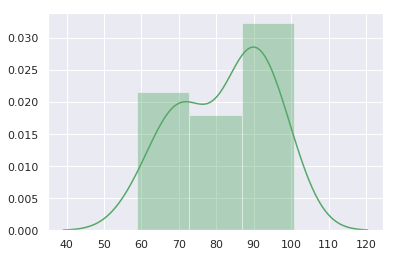

In [101]:
simulacion(cant_experimentos=20, cant_corridas=100, cant_pacientes=20, cant_quirofanos=4, cant_camas=30)


